

# 3. Gradient Domain Fusion

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

datadir = "/Users/marchon/Downloads/cs445_proj3/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

## Part 1 Toy Problem 

In [4]:
def toy_reconstruct(img):
    """ 
    Reconstruct this image from its gradient values, plus one pixel intensity. 
    Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). 
    For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im_h, im_w = img.shape
    n = im_h * (im_w - 1) + (im_h - 1) * im_w + 1
    
    # maps each pixel to a variable number
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    
    #"A" is a sparse matrix, and "b" is a known vector.
    A = scipy.sparse.lil_matrix((n, im_h * im_w))
    b = np.zeros(n)
    
    e = 0
    for x in range(im_h):
        for y in range(im_w):
            if x + 1 < im_h:
                A[e, im2var[x, y]] = 1
                A[e, im2var[x+1, y]] = -1
                b[e] = img[x, y] - img[x+1, y]
                e += 1
                
            if y + 1 < im_w:
                A[e, im2var[x, y]] = 1
                A[e, im2var[x, y+1]] = -1
                b[e] = img[x, y] - img[x, y+1]
                e += 1
                
    A[e, im2var[0, 0]] = 1
    b[e] = img[0, 0]
    
    # "v" are the variables to be solved.
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0]
    reconstruct_img = v.reshape(im_h, im_w)
  
    return reconstruct_img

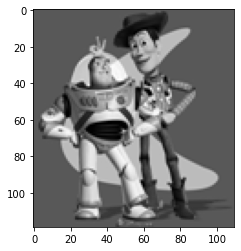

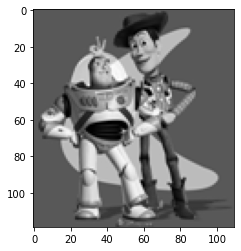

Max error is:  8.073677423559023e-06


In [5]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

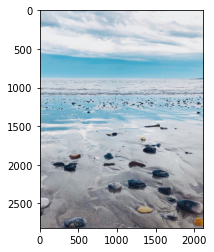

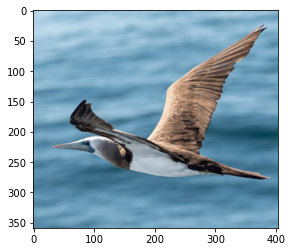

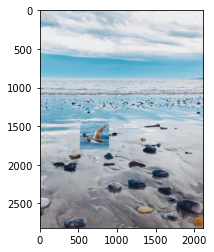

In [4]:
import importlib
import utils 
importlib.reload(utils)

background_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/bg_0.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/ob0.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (25, 400, 400, 25)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (700, 1800) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



In [5]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [6]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [7]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)

In [8]:
if use_interface:
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Part 2 Poisson Blending (50 pts)

In [26]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """

    ob_h, ob_w = object_img.shape
    bg_x, bg_y = bg_ul
    
    im2var = np.arange(ob_h * ob_w).reshape(ob_h, ob_w)
    mask_indices = im2var[object_mask > 0]
    
    # Number of equations
    neq = (ob_h * ob_w) + np.count_nonzero(object_mask) * 2
    
    # Initialize the sparse matrix A and vector b
    A = scipy.sparse.lil_matrix((neq, ob_h * ob_w), dtype=np.float64)
    b = np.zeros(neq, dtype=np.float64)
    
    e = 0
    for y in range(ob_w):
        for x in range(ob_h):
            if object_mask[x, y]:
                # for pixels within the object, create gradient constraints
                if x + 1 < ob_h:
                    A[e, im2var[x, y]] = 1
                    A[e, im2var[x+1, y]] = -1
                    b[e] = object_img[x, y] - object_img[x+1, y]
                    e += 1
                if y + 1 < ob_w:
                    A[e, im2var[x, y]] = 1
                    A[e, im2var[x, y+1]] = -1
                    b[e] = object_img[x, y] - object_img[x, y+1]
                    e += 1
                # for boundary pixels, match the background
                if x == 0 or x == ob_h-1 or y == 0 or y == ob_w-1:
                    A[e, im2var[x, y]] = 1
                    b[e] = bg_img[bg_x + x, bg_y + y]
                    e += 1
            else:
                # for pixels outside the object, match the background
                A[e, im2var[x, y]] = 1
                b[e] = bg_img[bg_x + x, bg_y + y]
                e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0]
    
    blended_img = np.copy(bg_img)
    blended_img_slice = blended_img[bg_x:bg_x + ob_h, bg_y:bg_y + ob_w]
    blended_img_slice[object_mask > 0] = v[mask_indices]
    blended_img[bg_x:bg_x + ob_h, bg_y:bg_y + ob_w] = blended_img_slice
    
    return blended_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


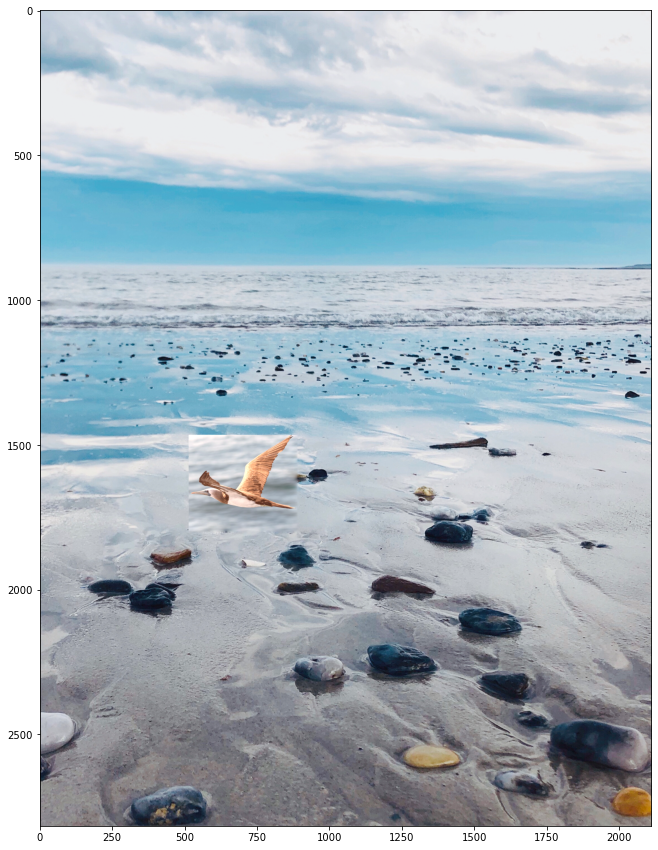

In [10]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

### Additional blending test 

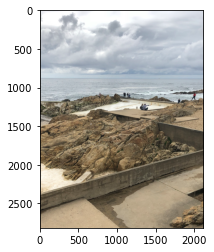

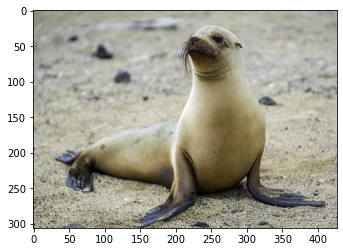

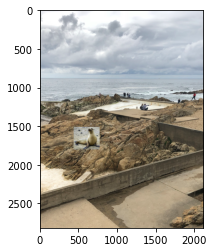

In [11]:
import importlib
import utils 
importlib.reload(utils)

background_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/im2.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/sea_lion.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:

  xs = (25, 359, 359, 25)
  ys = (15, 15, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (600, 1800) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


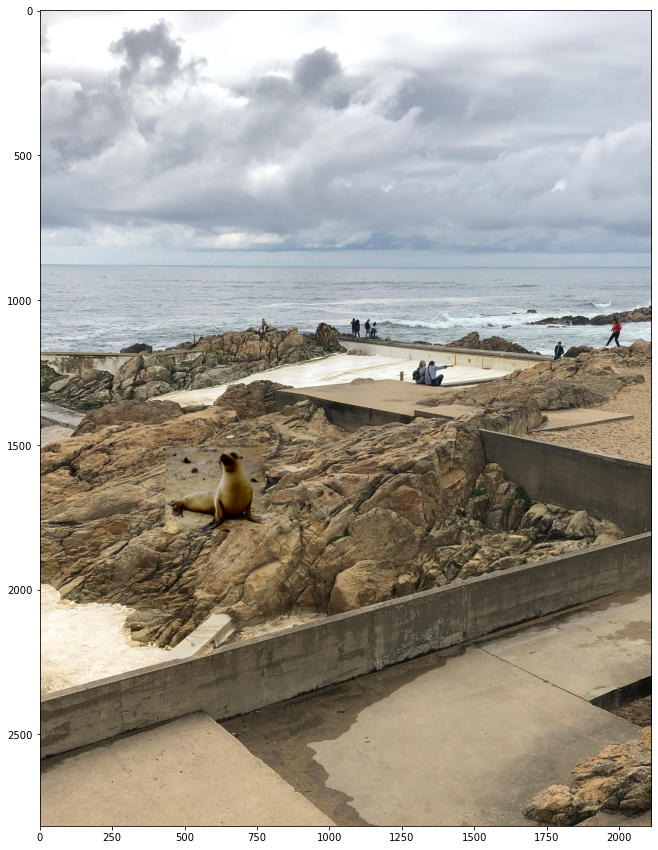

In [13]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

### Failure case 

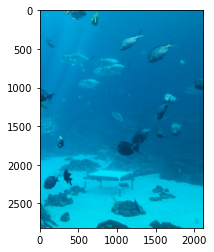

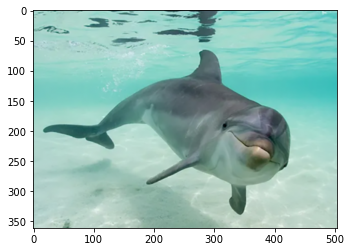

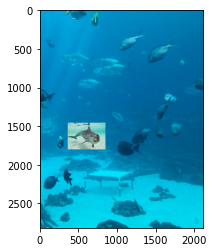

In [28]:
import importlib
import utils 
importlib.reload(utils)

background_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/bg_3.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/dolphin.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:

  xs = (15, 500, 500, 15)
  ys = (15, 15, 500, 500)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (600, 1800) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


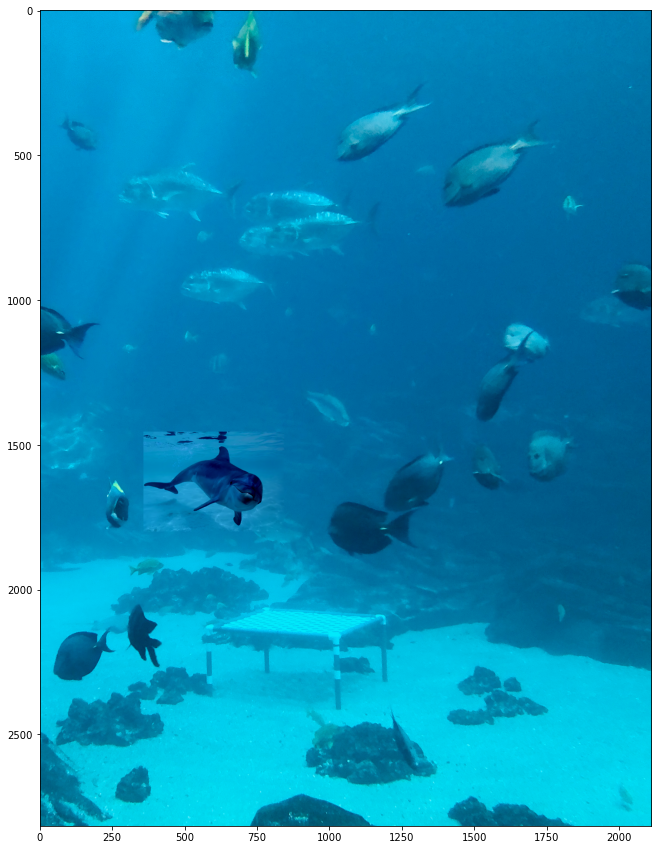

In [29]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [64]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    ob_h, ob_w = object_img.shape
    bg_h, bg_w = bg_img.shape
    bg_x, bg_y = bg_ul

    im2var = np.arange(ob_h * ob_w).reshape(ob_h, ob_w)
    mask_indices = im2var[object_mask > 0]
    
    # Number of equations
    neq = (ob_h * ob_w) + np.count_nonzero(object_mask) * 2

    # Initialize the sparse matrix A and vector b
    A = scipy.sparse.lil_matrix((neq, ob_h * ob_w), dtype=np.float64)
    b = np.zeros(neq, dtype=np.float64)

    e = 0
    for y in range(ob_w):
        for x in range(ob_h):
            if object_mask[x, y]:
                # for pixels within the object, create gradient constraints
                if x + 1 < ob_h:
                    g_obj = object_img[x, y] - object_img[x + 1, y]
                    g_bg = bg_img[bg_x + x, bg_y + y] - bg_img[bg_x + x + 1, bg_y + y]
                    # choose the gradient with the maximum magnitude
                    g = g_obj if abs(g_obj) > abs(g_bg) else g_bg
                    A[e, im2var[x, y]] = 1
                    A[e, im2var[x + 1, y]] = -1
                    b[e] = g
                    e += 1
                if y + 1 < ob_w:
                    g_obj = object_img[x, y] - object_img[x, y + 1]
                    g_bg = bg_img[bg_x + x, bg_y + y] - bg_img[bg_x + x, bg_y + y + 1]
                    # choose the gradient with the maximum magnitude
                    g = g_obj if abs(g_obj) > abs(g_bg) else g_bg
                    A[e, im2var[x, y]] = 1
                    A[e, im2var[x, y + 1]] = -1
                    b[e] = g
                    e += 1
                    
                # for pixels at the border of the mask, match the background
                if x == 0 or x == ob_h-1 or y == 0 or y == ob_w-1:
                    A[e, im2var[x, y]] = 1
                    b[e] = bg_img[bg_x + x, bg_y + y]
                    e += 1
            else:
                # for pixels outside the object, match the background
                A[e, im2var[x, y]] = 1
                b[e] = bg_img[bg_x + x, bg_y + y]
                e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0]
    
    blended_img = np.copy(bg_img)
    blended_img_slice = blended_img[bg_x:bg_x + ob_h, bg_y:bg_y + ob_w]
    blended_img_slice[object_mask > 0] = v[mask_indices].reshape(blended_img_slice[object_mask > 0].shape)
    blended_img[bg_x:bg_x + ob_h, bg_y:bg_y + ob_w] = blended_img_slice
    
    return blended_img

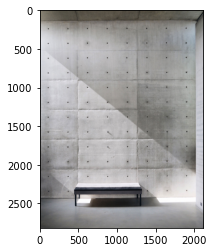

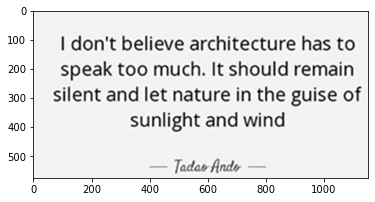

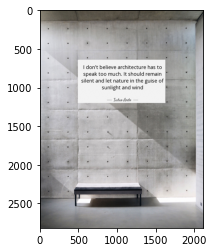

In [65]:
import importlib
import utils 
importlib.reload(utils)

background_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/wall.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('/Users/marchon/Downloads/cs445_proj3/samples/words.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:

  xs = (25, 1200, 1200, 25)
  ys = (15, 15, 900, 900)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (1050, 1200) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


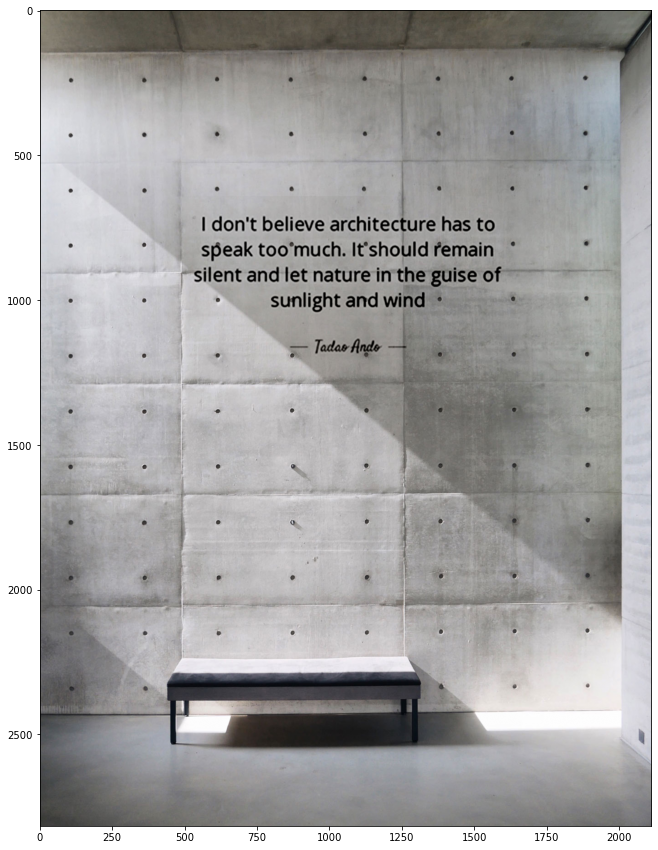

In [66]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)